In [2]:
import glob
import numpy as np
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import hyun_dataprocess as h_data
import tkinter as tk
from tkinter import filedialog

In [3]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [4]:
path = r'C:\Users\micke\Downloads\DataSet\DentalScreening\*'
npyPath = glob.glob(path)[3]
labelPath = glob.glob(path)[0]

In [5]:
def rotate_img(img, deg):
    n_rows, n_cols = img.shape[:2]
    
    if deg == 0:
        return img
    else:
        rotation_mat = cv.getRotationMatrix2D((n_cols // 2, n_rows // 2), deg, 1)
        rotated_img = cv.warpAffine(img, rotation_mat, (n_cols, n_rows))
        rotated_img = rotated_img[..., np.newaxis]
        
        return rotated_img

def read_data(imgs, labels, dtype=None, clip_range=None,
              udlr_idxs_to_crop=None, aug_flip_lr=False, aug_flip_ud=False, rotation_range=None):
    x = imgs
    y = labels
    
    if clip_range is not None:
        x = x[clip_range.start:clip_range.stop:clip_range.step, ...]
        y = y[clip_range.start:clip_range.stop:clip_range.step, ...]
    
    if udlr_idxs_to_crop is not None:
        x = x[:, udlr_idxs_to_crop[0]:udlr_idxs_to_crop[1], udlr_idxs_to_crop[2]:udlr_idxs_to_crop[3], :]
        
    if aug_flip_lr:
        x = np.concatenate((x, x[..., ::-1, :]))
        y = np.concatenate((y, y))
        
    if aug_flip_ud:
        x = np.concatenate((x, x[:, ::-1, ...]))
        y = np.concatenate((y, y))
        
    if rotation_range is not None:
        x = np.array([rotate_img(img, deg) for img in x for deg in rotation_range])
        y = np.repeat(y, len(rotation_range), axis=0)
    
    if dtype is not None:
        x = x.astype(dtype)
        y = y.astype(dtype)
    
#     print(x.dtype, x.shape)
#     jin_utils.print_mean_sd(x)
#     jin_utils.print_min_max(x)
#     print()
#     print(y.dtype, y.shape)
#     jin_utils.print_unique_cnt(y.astype(np.uint8))

    return x, y

In [6]:
class hyperparameters():
    def __init__(self):
        self.input_shape = ()
        self.udlr_idxs_to_crop = ()
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.epochs = 30
        
    def setparams(self,params):
        '''
        setparams[input_shape,udlr_idxs_to_crop,batch_size=32,epochs=1e-4,learning_rate=30]
        '''
        self.input_shape = params.get('input_shape')
        self.udlr_idxs_to_crop = params.get('udlr_idxs_to_crop')
        self.input_shape = (self.input_shape[0] - self.udlr_idxs_to_crop[0] + self.udlr_idxs_to_crop[1],
                            self.input_shape[1] - self.udlr_idxs_to_crop[2] + self.udlr_idxs_to_crop[3],
                            self.input_shape[2])
        self.batch_size = params.get('batch_size')
        self.epochs = params.get('epochs')
        self.learning_rate = params.get('learning_rate')        

In [7]:
class dataProcessing():
    class imgProcess():
    #     def __init__(self):
    #         self.imgs
        def read_npy(self,npyPath):
            return np.load(npyPath)

        def crop_img(self,imgs,croparea):
            '''
            Parameters
            ------------
            imgs : (n, width, height, channel)
                n : the number of imgs
            croparea : (x,y,width,height)
            '''
            imgs = imgs[:,croparea[0]:croparea[1],croparea[2]:croparea[3],:]
            return imgs
        def divide_imgs(self,imgs,testCount,trainCount = None):
            '''
             Parameters
            ------------
            imgs : full data set 
                (n, width, height, channel)
                n : the number of imgs
            testCount : the number of testset img
            trainCount : the number of trainset img
            '''
            testImgs = imgs[:testCount,...]
            if trainCount is not None:
                trainImgs = imgs[-trainCount :,...]
            else :
                trainImgs = imgs[testCount :,...]
            return testImgs, trainImgs
    class labelProcess():
        def divide_labels(self,labels,testCount,trainCount = None):
            testLabels = labels[:testCount]
            if trainCount is not None:
                trainLabels = labels[-trainCount :,...]
            else :
                trainLabels = labels[testCount :,...]
            return testLabels, trainLabels

In [90]:
# class modelBuild():
# #     def __init__(self):
# #         self.model
        
#     def bulid_ResNet50V2(self, input_shape=None):
#         base_model = ResNet50V2(include_top=False, weights=None, input_shape=input_shape)

#         x = base_model.output
#         x = tf.keras.layers.GlobalAveragePooling2D(name='gap')(x)

#         x = tf.keras.layers.Dense(512, activation='relu', name='fc1')(x)
#         x = tf.keras.layers.Dense(256, activation='relu', name='fc2')(x)
#         main_output = tf.keras.layers.Dense(1, name='fc3')(x)

#         model = tf.keras.models.Model(inputs=base_model.input, outputs=main_output, name='resnet50_v2')

#         return model

In [8]:
class modelMaker():
    def __init__(self,hyperparameters):
        self.history = None
        self.input_shape = hyperparameters.input_shape
        self.batch_size = hyperparameters.batch_size
        self.learning_rate = hyperparameters.learning_rate
        self.epochs = hyperparameters.epochs
        
    def bulid_model_ResNet50V2(self):
        base_model = ResNet50V2(include_top=False, weights=None, input_shape=self.input_shape)

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D(name='gap')(x)

        x = tf.keras.layers.Dense(512, activation='relu', name='fc1')(x)
        x = tf.keras.layers.Dense(256, activation='relu', name='fc2')(x)
        main_output = tf.keras.layers.Dense(1, name='fc3')(x)

        model = tf.keras.models.Model(inputs=base_model.input, outputs=main_output, name='resnet50_v2')
        return model
        
    def compile_model(self, model,optimizer = tf.optimizers.Adam):
        
        model.compile(optimizer=optimizer(lr=self.learning_rate),
                  loss=tf.keras.losses.mean_squared_error, metrics=['mae'])
        return model
        
    def fit_model(self,model,trainImgs,trainLabels,testImgs=None,testLabels=None):
        if (testImgs is None and testLabels is None):
            history = model.fit(trainImgs, trainLabels,
                                 batch_size=self.batch_size,
                                 epochs=self.epochs)
            
        else:
            history = model.fit(trainImgs, trainLabels,
                                     batch_size=self.batch_size,
                                     epochs=self.epochs,
                                     validation_data=(testImgs, testLabels))
        return history
    
    def load_model(self):
        root = tk.Tk()
        root.filename =  tk.filedialog.askopenfilename(initialdir = "C:",title = "choose your file",filetypes =(("h5 files","*.h5"),("all files","*.*")))
        root.withdraw()
        model = tf.keras.models.load_model(root.filename)
        return model

In [9]:
class visualize():
    def __init__(self):
        self.figsize = (14,4)
    def plotHistory(self,history):
        dict_hist = history.history
        list_hist = list(dict_hist.keys())
        plt.figure(figsize=self.figsize)
        plt.subplot(121)
        plt.title(list_hist[0])
        plt.plot(hist[list_hist[0]],'bo',label = list_hist[0])
        plt.plot(hist[list_hist[2]],'g',label = list_hist[2])
        plt.legend()

        plt.subplot(122)
        plt.title(list_hist[1])
        plt.plot(hist[list_hist[1]],'bo',label = list_hist[1])
        plt.plot(hist[list_hist[3]],'g',label = list_hist[3])
        plt.legend()
        plt.show()
    def drawHeatmap(self):
        # todo
        pass

In [24]:
class logger():
    def save_weight(self,model,modelName):
        root = tk.Tk()
        root.filename = tk.filedialog.askdirectory(initialdir ="C:/")
        root.withdraw()
        path = root.filename+ "/"
        model.save(path+modelName)
        print("Model Save : Done")
        
    def save_heatmap(self,img,imgName):
        root = tk.Tk()
        root.filename = tk.filedialog.askdirectory(initialdir ="C:/")
        root.withdraw()
        path = root.filename+ "/"
        cv.imwrite(path+imgName,img)
        print("Img Save : Done")

In [15]:
param1 =  {'input_shape': (256, 512, 1),
          'udlr_idxs_to_crop': (30, -30, 60, -60), 
          'batch_size': 32,
          'learning_rate': 1e-4,
          'initial_epoch': 0,
          'epochs': 100,
          'checkpoint_period': 1}
params = hyperparameters()
params.setparams(param1)

In [17]:
ip = dataProcessing.imgProcess()
imgs = ip.read_npy(npyPath)
imgs = ip.crop_img(imgs,params.udlr_idxs_to_crop)
trainImgs, testImgs = ip.divide_imgs(imgs, 400)

In [18]:
lp = dataProcessing.labelProcess()
labels = h_data.getLabel(labelPath,[1])
trainLabels, testLabels = lp.divide_labels(labels,400)

In [19]:
x_train, y_train = read_data(trainImgs, trainLabels, dtype=np.float32,
                             aug_flip_lr=True, aug_flip_ud=True, rotation_range=range(-10, 11, 2))
x_test, y_test = read_data(testImgs, testLabels, dtype=np.float32, aug_flip_lr=True)


In [20]:
modelM = modelMaker(params)
model = modelM.bulid_model_ResNet50V2()
model = modelM.compile_model(model)
history = modelM.fit_model(model,x_train,y_train,x_test,y_test)

Train on 17600 samples, validate on 166 samples
Epoch 1/100
17600/17600 [==============================] - 149s 8ms/sample - loss: 20.2467 - mae: 2.3464 - val_loss: 212.9158 - val_mae: 12.4482
Epoch 2/100
17600/17600 [==============================] - 138s 8ms/sample - loss: 2.0401 - mae: 1.0888 - val_loss: 4.3509 - val_mae: 1.6043
Epoch 3/100
17600/17600 [==============================] - 138s 8ms/sample - loss: 0.8883 - mae: 0.7308 - val_loss: 3.9573 - val_mae: 1.6454
Epoch 4/100
17600/17600 [==============================] - 138s 8ms/sample - loss: 0.6485 - mae: 0.6211 - val_loss: 3.3295 - val_mae: 1.4333
Epoch 5/100
17600/17600 [==============================] - 138s 8ms/sample - loss: 0.5702 - mae: 0.5797 - val_loss: 3.2782 - val_mae: 1.4489
Epoch 6/100
17600/17600 [==============================] - 141s 8ms/sample - loss: 0.3548 - mae: 0.4605 - val_loss: 4.8388 - val_mae: 1.8841
Epoch 7/100
17600/17600 [==============================] - 139s 8ms/sample - loss: 0.3678 - mae: 0.474

In [23]:
model.save("model.h5")

In [21]:
log = logger()

In [22]:
log.save_weight(model,"model.h5")

AttributeError: 'Model' object has no attribute 'save_model'

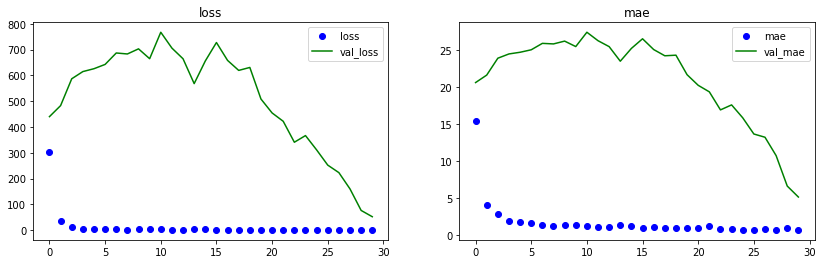

In [140]:
vis = visualize()
vis.plotHistory(history)